Load packages and functions

In [2]:
import torch
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import transformers
import tensorflow as tf
from models_1 import GPTModel
from helper_function import *
from load_gpt2 import *
from Lora_helper import *
from train import *

set up the cuda device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print cuda name
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Iterate over the available GPUs and print their names
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("CUDA is not available.")

Number of available GPUs: 4
GPU 0: Tesla V100-SXM2-32GB
GPU 1: Tesla V100-SXM2-32GB
GPU 2: Tesla V100-SXM2-32GB
GPU 3: Tesla V100-SXM2-32GB


## Data

The data we use is from huggingface called yelp_review_full. The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. There are 1 star reviews through 5 star reviews. We want to develop a model that is capabable of classify the review score based on the text. In total there are 650,000 trainig samples and 50,000 testing samples.

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


We set the context window to 300 according to EDA, which would be good for most cases.

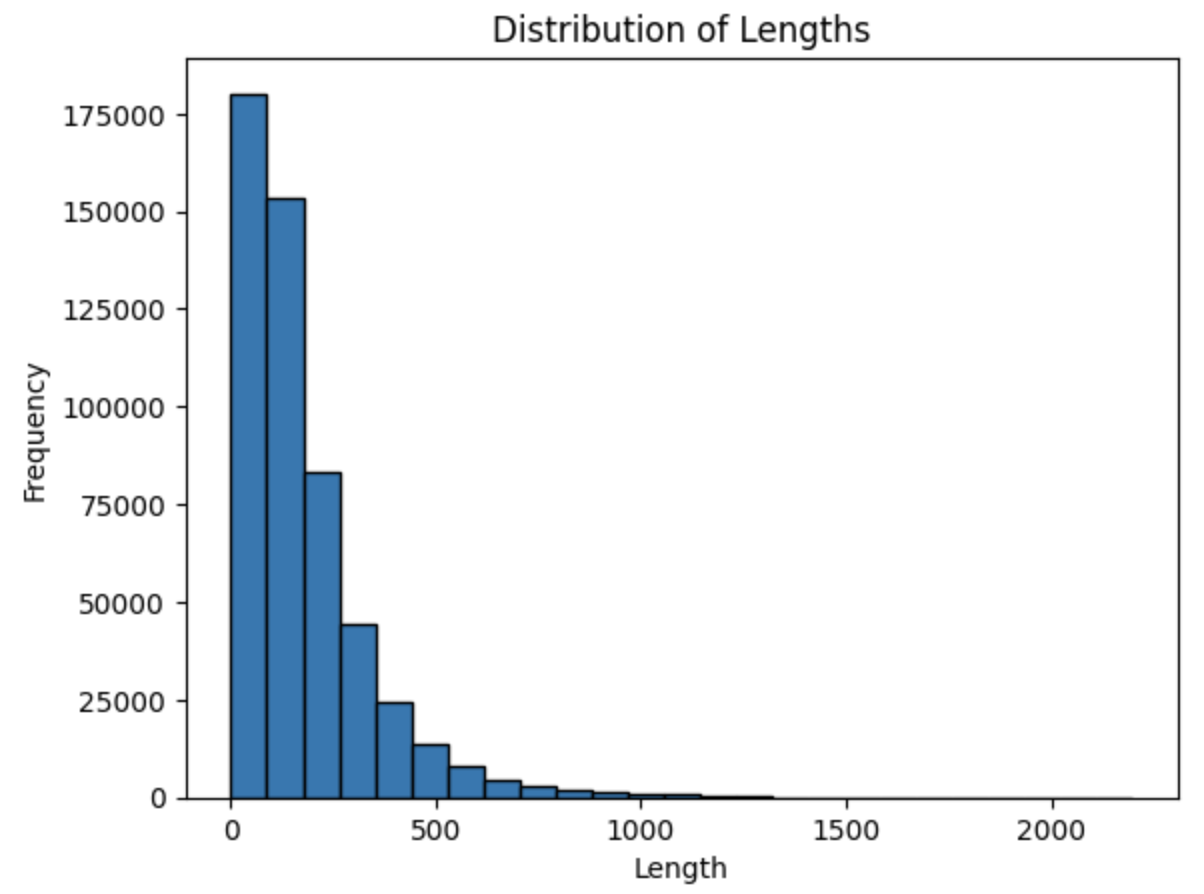

We define the training, validation, and testing using stratified sampling, ensuring that the data is balanced.

In [5]:
window_size = 300

train_dataset = RatingDataset(
    csv_file="data/train_df.csv",
    max_length=window_size,
    tokenizer=tokenizer
)
val_dataset = RatingDataset(
    csv_file="data/val_df.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = RatingDataset(
    csv_file="data/test_df.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
print(train_dataset.max_length)

300


We define the dataloader here.

In [6]:
from torch.utils.data import DataLoader

num_workers = 4
batch_size = 32

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

We print a sample from train loader. There are 32 mini-batches in one batch and each has length of 300 for text and 1 for target. We use padding when the length of input is shorter than 300.

In [7]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    print('text')
    print(token_ids_to_text(input_batch[0], tokenizer))
    print('label')
    print(target_batch[0])
    break

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
text
They actually open at 11:00 am , not 9:00. Also, the address listed is wrong. It is actually 2630 rio solado parkway. Other than that, the facility is okay. Staff isn't very tentative.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|en

## Model

#### Load GPT2 pretrained model

The model we chose was the smaller variation of GPT2 which has 124M parameters. This is becasue our computation resource is constrained. We want to experiment with different training method and different model variation, rather than achieving high benchmarks.

In [8]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [24]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [10]:
# try the pretrained model and make sure it is loaded correctly 
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


### Modify the architecture of the base model

We will try five methods to modify and finetune the base model. First is training all layers with LoRA; second is training all layers without LoRA; third is training only the last one layer; forth is training only the last two layers; fifth is training only the last three layers.

#### LoRA

We first need to define the out head with number of class.

In [9]:
torch.manual_seed(123)
num_classes = 5
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)

Before applying LoRA, we first freeze all parameters in the model. We can see after we have freezed the model, there was 0 trainable parameter.

In [10]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")
 
for param in model.parameters():
    param.requires_grad = False
 
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,443,653
Total trainable parameters after: 0


Then we can apply LoRA to the model. Note Rank is a hyper parameter which is the inner dimmension of matrix A and matrix B. Alpha is the scaling factor or strengh of LoRA. It is the degree to which the output from the adapted layer can impact the original layer's output.

In [11]:
replace_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 2,666,576


As we can see, the number of trainable parameters decreases drastically due to low rank representation of the original model.

#### Finetune with all layers

In [9]:
num_classes = 5
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

#### Finetune with last one layer

In [14]:
for param in model.parameters():
    param.requires_grad = False

In [15]:
num_classes = 5
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [16]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

#### Finetune with last two layers

In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
num_classes = 5
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [21]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.trf_blocks[-2].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

#### Finetune with last three layers

In [25]:
for param in model.parameters():
    param.requires_grad = False

In [26]:
num_classes = 5
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [27]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.trf_blocks[-2].parameters():
    param.requires_grad = True

for param in model.trf_blocks[-3].parameters():
    param.requires_grad = True
    
for param in model.final_norm.parameters():
    param.requires_grad = True

## Training

### LoRA Training

We first evaluate the model without training

In [19]:
torch.manual_seed(42) # For reproducibility due to the shuffling in the training data loader

model = torch.nn.DataParallel(model)
model.to(device)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=50)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=50)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=50)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 19.50%
Validation accuracy: 19.25%
Test accuracy: 19.81%


As we can see here, the accuracy is similar to random guess. Accuracy across all loaders is similar because we use stratified sampling. Now we can train models here with imported functions.

In [14]:
# epoch 1
import time
from train import *
start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.362, Val loss 3.410
Ep 1 (Step 000050): Train loss 1.629, Val loss 1.630
Ep 1 (Step 000100): Train loss 1.582, Val loss 1.601
Ep 1 (Step 000150): Train loss 1.576, Val loss 1.615
Ep 1 (Step 000200): Train loss 1.599, Val loss 1.621
Ep 1 (Step 000250): Train loss 1.165, Val loss 1.165
Ep 1 (Step 000300): Train loss 1.056, Val loss 1.163
Ep 1 (Step 000350): Train loss 1.037, Val loss 0.996
Ep 1 (Step 000400): Train loss 1.017, Val loss 0.926
Ep 1 (Step 000450): Train loss 0.995, Val loss 0.901
Ep 1 (Step 000500): Train loss 0.866, Val loss 0.921
Ep 1 (Step 000550): Train loss 1.038, Val loss 1.039
Ep 1 (Step 000600): Train loss 0.907, Val loss 0.886
Ep 1 (Step 000650): Train loss 0.869, Val loss 0.878
Ep 1 (Step 000700): Train loss 0.994, Val loss 0.944
Ep 1 (Step 000750): Train loss 0.988, Val loss 0.904
Ep 1 (Step 000800): Train loss 0.889, Val loss 0.870
Ep 1 (Step 000850): Train loss 0.863, Val loss 0.865
Ep 1 (Step 000900): Train loss 0.861, Val loss

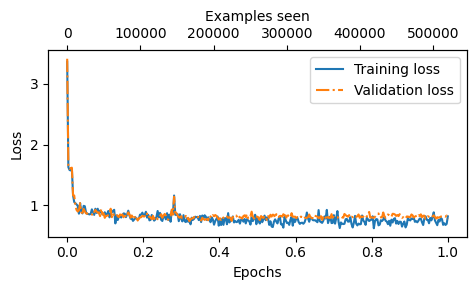

In [15]:
# plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

As we can see here, the loss is very high at the begaining. But as we train more steps, the loss for validation and training decreased. At the end of the first epoch, our accuracy is much higher than the un-trained model.

In [16]:
# epoch 2
start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.685, Val loss 0.800
Ep 1 (Step 000050): Train loss 0.754, Val loss 0.814
Ep 1 (Step 000100): Train loss 0.767, Val loss 0.839
Ep 1 (Step 000150): Train loss 0.680, Val loss 0.803
Ep 1 (Step 000200): Train loss 0.762, Val loss 0.819
Ep 1 (Step 000250): Train loss 0.831, Val loss 0.847
Ep 1 (Step 000300): Train loss 0.681, Val loss 0.832
Ep 1 (Step 000350): Train loss 0.721, Val loss 0.806
Ep 1 (Step 000400): Train loss 0.727, Val loss 0.797
Ep 1 (Step 000450): Train loss 0.817, Val loss 0.795
Ep 1 (Step 000500): Train loss 0.638, Val loss 0.802
Ep 1 (Step 000550): Train loss 0.686, Val loss 0.816
Ep 1 (Step 000600): Train loss 0.655, Val loss 0.809
Ep 1 (Step 000650): Train loss 0.671, Val loss 0.826
Ep 1 (Step 000700): Train loss 0.831, Val loss 0.790
Ep 1 (Step 000750): Train loss 0.668, Val loss 0.828
Ep 1 (Step 000800): Train loss 0.849, Val loss 0.856
Ep 1 (Step 000850): Train loss 0.731, Val loss 0.792
Ep 1 (Step 000900): Train loss 0.800, Val loss

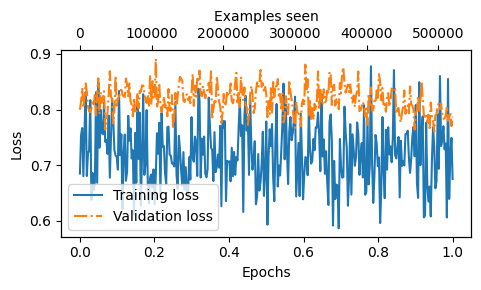

In [17]:
# plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [18]:
# inference and save it now
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=200)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=200)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=200)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 68.81%
Validation accuracy: 67.23%
Test accuracy: 65.73%


For the second epoch, the training progress is slower than the first epoch. This might because the model is not capable enough for this task, or becasue the inherit noise in the dataset. which makes it hard for model to converge. 

In [20]:
# epoch 3
start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.648, Val loss 0.759
Ep 1 (Step 000050): Train loss 0.807, Val loss 0.777
Ep 1 (Step 000100): Train loss 0.751, Val loss 0.869
Ep 1 (Step 000150): Train loss 0.756, Val loss 0.801
Ep 1 (Step 000200): Train loss 0.689, Val loss 0.801
Ep 1 (Step 000250): Train loss 0.779, Val loss 0.862
Ep 1 (Step 000300): Train loss 0.637, Val loss 0.772
Ep 1 (Step 000350): Train loss 0.640, Val loss 0.809
Ep 1 (Step 000400): Train loss 0.608, Val loss 0.802
Ep 1 (Step 000450): Train loss 0.623, Val loss 0.802
Ep 1 (Step 000500): Train loss 0.577, Val loss 0.798
Ep 1 (Step 000550): Train loss 0.731, Val loss 0.830
Ep 1 (Step 000600): Train loss 0.701, Val loss 0.804
Ep 1 (Step 000650): Train loss 0.630, Val loss 0.789
Ep 1 (Step 000700): Train loss 0.712, Val loss 0.792
Ep 1 (Step 000750): Train loss 0.725, Val loss 0.816
Ep 1 (Step 000800): Train loss 0.698, Val loss 0.796
Ep 1 (Step 000850): Train loss 0.658, Val loss 0.825
Ep 1 (Step 000900): Train loss 0.744, Val loss

KeyboardInterrupt: 

In [22]:
# inference and save it now
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=200)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=200)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=200)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 69.58%
Validation accuracy: 67.67%
Test accuracy: 66.69%


We used early stopping to prevent over-fitting in the end of the third epoch. We can see that here the loss for training is much lower than the loss for validation. This indicates potential over-fitting. So we decided to stop training here. Finally we managed to increased the accuracy.

#### Inference

In [12]:
checkpoint = torch.load('models/Lora_3.pth')
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

We first calculate the accuracy for all data in testing dataset. Then we use confusion matrix to see how well did the model predict for each individual class. we observe that the model demonstrates strong performance for classes 1 and 5, with 7,980 and 7,796 correct predictions respectively. However, there is notable confusion between adjacent classes, particularly between classes 2 and 3, and classes 3 and 4. This pattern suggests that the model may struggle to distinguish between similar categories. The matrix also reveals some instances of severe misclassification, such as 54 samples from class 1 being incorrectly classified as class 5. This comprehensive view of the model's performance across all classes provides valuable insights for further refinement and optimization of the classification algorithm.

In [13]:
model.to(device)
accuracy_confusion_matrix(model, device, test_loader)

Accuracy: 0.67
Confusion Matrix:
[[7980 1812  127   27   54]
 [1998 6421 1402  113   66]
 [ 284 2076 5867 1507  266]
 [  82  183 1647 5440 2648]
 [  99   45  201 1859 7796]]


array([[7980, 1812,  127,   27,   54],
       [1998, 6421, 1402,  113,   66],
       [ 284, 2076, 5867, 1507,  266],
       [  82,  183, 1647, 5440, 2648],
       [  99,   45,  201, 1859, 7796]])

### Training with all layer

In [10]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 124,443,653


Here we have all parameters trainable which means it would take a lot longer to finetune our model

In [13]:
# initial optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

Ep 1 (Step 000000): Train loss 3.996, Val loss 3.771
Ep 1 (Step 000050): Train loss 1.768, Val loss 1.663
Ep 1 (Step 000100): Train loss 1.613, Val loss 1.631
Ep 1 (Step 000150): Train loss 1.662, Val loss 1.627
Ep 1 (Step 000200): Train loss 1.564, Val loss 1.623
Ep 1 (Step 000250): Train loss 1.583, Val loss 1.605
Ep 1 (Step 000300): Train loss 1.433, Val loss 1.433
Ep 1 (Step 000350): Train loss 1.240, Val loss 1.265
Ep 1 (Step 000400): Train loss 1.083, Val loss 1.035
Ep 1 (Step 000450): Train loss 1.013, Val loss 1.005
Ep 1 (Step 000500): Train loss 0.981, Val loss 1.026
Ep 1 (Step 000550): Train loss 0.849, Val loss 0.900
Ep 1 (Step 000600): Train loss 0.860, Val loss 0.861
Ep 1 (Step 000650): Train loss 1.083, Val loss 0.884
Ep 1 (Step 000700): Train loss 0.866, Val loss 0.878
Ep 1 (Step 000750): Train loss 0.933, Val loss 0.897
Ep 1 (Step 000800): Train loss 0.889, Val loss 0.842
Ep 1 (Step 000850): Train loss 0.821, Val loss 0.815
Ep 1 (Step 000900): Train loss 0.872, Val loss

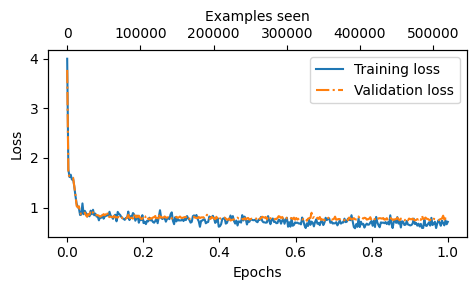

In [14]:
import time
from train import *
# epoch 1
start_time = time.time()


num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")
# plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Here the model performed similarly compared to using LoRA. But it takes less time which is unexpected

Ep 1 (Step 000000): Train loss 0.786, Val loss 0.784
Ep 1 (Step 000050): Train loss 0.757, Val loss 0.763
Ep 1 (Step 000100): Train loss 0.632, Val loss 0.751
Ep 1 (Step 000150): Train loss 0.590, Val loss 0.784
Ep 1 (Step 000200): Train loss 0.619, Val loss 0.773
Ep 1 (Step 000250): Train loss 0.648, Val loss 0.785
Ep 1 (Step 000300): Train loss 0.701, Val loss 0.809
Ep 1 (Step 000350): Train loss 0.640, Val loss 0.785
Ep 1 (Step 000400): Train loss 0.667, Val loss 0.748
Ep 1 (Step 000450): Train loss 0.633, Val loss 0.800
Ep 1 (Step 000500): Train loss 0.662, Val loss 0.834
Ep 1 (Step 000550): Train loss 0.637, Val loss 0.764
Ep 1 (Step 000600): Train loss 0.701, Val loss 0.742
Ep 1 (Step 000650): Train loss 0.581, Val loss 0.770
Ep 1 (Step 000700): Train loss 0.709, Val loss 0.756
Ep 1 (Step 000750): Train loss 0.793, Val loss 0.760
Ep 1 (Step 000800): Train loss 0.608, Val loss 0.723
Ep 1 (Step 000850): Train loss 0.646, Val loss 0.782
Ep 1 (Step 000900): Train loss 0.684, Val loss

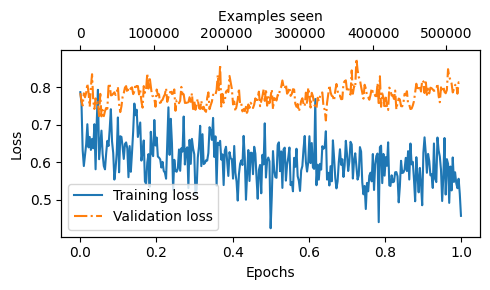

In [15]:
# epoch 2
start_time = time.time()


num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")
# plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Here we can see that training loss is much lower than the validation loss and validation loss has been bouncing around. So we decided to stop training to prevent further overfitting

In [17]:
torch.manual_seed(42) # For reproducibility due to the shuffling in the training data loader

val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=200)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=200)

print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Validation accuracy: 69.03%
Test accuracy: 68.41%


Here we sampled 200 batches and we can see that the accuracy is similar to using LoRA but slightly better

#### Inference

In [11]:
checkpoint = torch.load('models/All_2.pth')
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

We first calculate accuracy for test dataset and then we draw a confusion matrix. We see that accuracy is a little bit better than using LoRA. This is suprising because we trained nearly 3 epochs of LoRA. The reason that LoRA is worse might be overfitting. Confusion matrix showed a similar pattern as LoRA model. The distribution is similar for the matrix. We believe that this is due to noise from the training data. 

In [12]:
model.to(device)
accuracy_confusion_matrix(model, device, test_loader)

Accuracy: 0.68
Confusion Matrix:
[[8108 1717  102   20   53]
 [2015 6405 1454   89   37]
 [ 240 1965 5910 1704  181]
 [  49  132 1379 6152 2288]
 [  64   36  136 2163 7601]]


array([[8108, 1717,  102,   20,   53],
       [2015, 6405, 1454,   89,   37],
       [ 240, 1965, 5910, 1704,  181],
       [  49,  132, 1379, 6152, 2288],
       [  64,   36,  136, 2163, 7601]])

### Training with last one layer

In [17]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 7,093,253


As we can see here we have less trainable parameters becasue we have freezed most of them

In [14]:
model.to(device)
torch.manual_seed(42) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=50)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=50)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=50)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 19.56%
Validation accuracy: 19.12%
Test accuracy: 19.88%


Accuracy is very low similar to last chunk before we train the model

In [15]:
# Epoch 1
import time
from train import *
start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.738, Val loss 10.111
Ep 1 (Step 000050): Train loss 2.687, Val loss 2.612
Ep 1 (Step 000100): Train loss 2.115, Val loss 2.189
Ep 1 (Step 000150): Train loss 1.766, Val loss 1.890
Ep 1 (Step 000200): Train loss 1.774, Val loss 1.753
Ep 1 (Step 000250): Train loss 1.659, Val loss 1.695
Ep 1 (Step 000300): Train loss 1.739, Val loss 1.667
Ep 1 (Step 000350): Train loss 1.599, Val loss 1.650
Ep 1 (Step 000400): Train loss 1.619, Val loss 1.645
Ep 1 (Step 000450): Train loss 1.614, Val loss 1.628
Ep 1 (Step 000500): Train loss 1.625, Val loss 1.625
Ep 1 (Step 000550): Train loss 1.585, Val loss 1.611
Ep 1 (Step 000600): Train loss 1.579, Val loss 1.601
Ep 1 (Step 000650): Train loss 1.561, Val loss 1.588
Ep 1 (Step 000700): Train loss 1.545, Val loss 1.579
Ep 1 (Step 000750): Train loss 1.486, Val loss 1.535
Ep 1 (Step 000800): Train loss 1.473, Val loss 1.491
Ep 1 (Step 000850): Train loss 1.439, Val loss 1.443
Ep 1 (Step 000900): Train loss 1.411, Val los

In [18]:
checkpoint = torch.load('models/Last_one.pth')
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [19]:
# Epoch 2
import time
from train import *
start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.770, Val loss 0.874
Ep 1 (Step 000050): Train loss 0.897, Val loss 0.874
Ep 1 (Step 000100): Train loss 0.874, Val loss 0.869
Ep 1 (Step 000150): Train loss 0.833, Val loss 0.891
Ep 1 (Step 000200): Train loss 0.870, Val loss 0.879
Ep 1 (Step 000250): Train loss 0.901, Val loss 0.867
Ep 1 (Step 000300): Train loss 0.844, Val loss 0.879
Ep 1 (Step 000350): Train loss 0.871, Val loss 0.887
Ep 1 (Step 000400): Train loss 0.891, Val loss 0.896
Ep 1 (Step 000450): Train loss 0.866, Val loss 0.879
Ep 1 (Step 000500): Train loss 0.868, Val loss 0.874
Ep 1 (Step 000550): Train loss 0.754, Val loss 0.882
Ep 1 (Step 000600): Train loss 0.760, Val loss 0.871
Ep 1 (Step 000650): Train loss 0.861, Val loss 0.864
Ep 1 (Step 000700): Train loss 0.806, Val loss 0.859
Ep 1 (Step 000750): Train loss 0.965, Val loss 0.872
Ep 1 (Step 000800): Train loss 0.935, Val loss 0.860
Ep 1 (Step 000850): Train loss 0.801, Val loss 0.864
Ep 1 (Step 000900): Train loss 1.010, Val loss

In [21]:
# Epoch 3
import time
from train import *
start_time = time.time()

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.901, Val loss 0.838
Ep 1 (Step 000050): Train loss 0.831, Val loss 0.860
Ep 1 (Step 000100): Train loss 0.815, Val loss 0.855
Ep 1 (Step 000150): Train loss 0.846, Val loss 0.841
Ep 1 (Step 000200): Train loss 0.911, Val loss 0.843
Ep 1 (Step 000250): Train loss 0.742, Val loss 0.842
Ep 1 (Step 000300): Train loss 0.868, Val loss 0.837
Ep 1 (Step 000350): Train loss 0.922, Val loss 0.844
Ep 1 (Step 000400): Train loss 0.792, Val loss 0.833
Ep 1 (Step 000450): Train loss 0.868, Val loss 0.833
Ep 1 (Step 000500): Train loss 0.842, Val loss 0.847
Ep 1 (Step 000550): Train loss 0.735, Val loss 0.832
Ep 1 (Step 000600): Train loss 0.852, Val loss 0.827
Ep 1 (Step 000650): Train loss 0.862, Val loss 0.846
Ep 1 (Step 000700): Train loss 0.855, Val loss 0.827
Ep 1 (Step 000750): Train loss 0.769, Val loss 0.826
Ep 1 (Step 000800): Train loss 0.761, Val loss 0.822
Ep 1 (Step 000850): Train loss 0.710, Val loss 0.840
Ep 1 (Step 000900): Train loss 0.805, Val loss

In [22]:
model.to(device)
accuracy_confusion_matrix(model, device, test_loader)

Accuracy: 0.64
Confusion Matrix:
[[7602 2068  189   61   80]
 [2030 5841 1849  192   88]
 [ 314 2008 5443 1934  301]
 [  90  183 1672 5263 2792]
 [ 102   41  253 1929 7675]]


array([[7602, 2068,  189,   61,   80],
       [2030, 5841, 1849,  192,   88],
       [ 314, 2008, 5443, 1934,  301],
       [  90,  183, 1672, 5263, 2792],
       [ 102,   41,  253, 1929, 7675]])

### Training with last two layer

In [14]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 14,181,125


In [16]:
torch.manual_seed(42) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=50)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=50)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=50)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 20.06%
Validation accuracy: 21.12%
Test accuracy: 21.62%


Low accuracy indicates that the model is not trained yet.

In [15]:
# epoch 1
import time
from train import *
start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.289, Val loss 9.528
Ep 1 (Step 000050): Train loss 1.928, Val loss 2.012
Ep 1 (Step 000100): Train loss 1.645, Val loss 1.701
Ep 1 (Step 000150): Train loss 1.748, Val loss 1.644
Ep 1 (Step 000200): Train loss 1.644, Val loss 1.642
Ep 1 (Step 000250): Train loss 1.747, Val loss 1.656
Ep 1 (Step 000300): Train loss 1.616, Val loss 1.630
Ep 1 (Step 000350): Train loss 1.622, Val loss 1.645
Ep 1 (Step 000400): Train loss 1.638, Val loss 1.622
Ep 1 (Step 000450): Train loss 1.609, Val loss 1.619
Ep 1 (Step 000500): Train loss 1.595, Val loss 1.613
Ep 1 (Step 000550): Train loss 1.603, Val loss 1.609
Ep 1 (Step 000600): Train loss 1.597, Val loss 1.605
Ep 1 (Step 000650): Train loss 1.618, Val loss 1.596
Ep 1 (Step 000700): Train loss 1.564, Val loss 1.573
Ep 1 (Step 000750): Train loss 1.532, Val loss 1.511
Ep 1 (Step 000800): Train loss 1.405, Val loss 1.419
Ep 1 (Step 000850): Train loss 1.281, Val loss 1.312
Ep 1 (Step 000900): Train loss 1.208, Val loss

As we can see here, accuracy is much higher. Now we will train another epoch

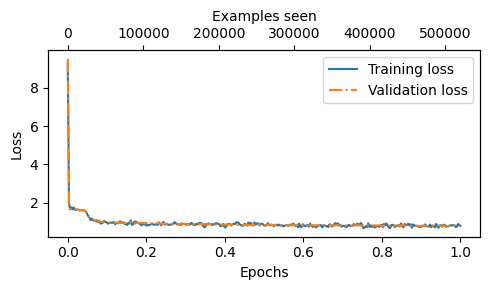

In [16]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [16]:
import time
from train import *
start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.658, Val loss 0.796
Ep 1 (Step 000050): Train loss 0.888, Val loss 0.797
Ep 1 (Step 000100): Train loss 0.768, Val loss 0.787
Ep 1 (Step 000150): Train loss 0.723, Val loss 0.772
Ep 1 (Step 000200): Train loss 0.856, Val loss 0.774
Ep 1 (Step 000250): Train loss 0.702, Val loss 0.781
Ep 1 (Step 000300): Train loss 0.805, Val loss 0.767
Ep 1 (Step 000350): Train loss 0.767, Val loss 0.765
Ep 1 (Step 000400): Train loss 0.806, Val loss 0.777
Ep 1 (Step 000450): Train loss 0.785, Val loss 0.786
Ep 1 (Step 000500): Train loss 0.738, Val loss 0.776
Ep 1 (Step 000550): Train loss 0.755, Val loss 0.789
Ep 1 (Step 000600): Train loss 0.701, Val loss 0.779
Ep 1 (Step 000650): Train loss 0.857, Val loss 0.783
Ep 1 (Step 000700): Train loss 0.799, Val loss 0.774
Ep 1 (Step 000750): Train loss 0.805, Val loss 0.772
Ep 1 (Step 000800): Train loss 0.714, Val loss 0.781
Ep 1 (Step 000850): Train loss 0.720, Val loss 0.796
Ep 1 (Step 000900): Train loss 0.870, Val loss

In [17]:
import time
from train import *
start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.824, Val loss 0.763
Ep 1 (Step 000050): Train loss 0.834, Val loss 0.765
Ep 1 (Step 000100): Train loss 0.623, Val loss 0.758
Ep 1 (Step 000150): Train loss 0.679, Val loss 0.762
Ep 1 (Step 000200): Train loss 0.707, Val loss 0.761
Ep 1 (Step 000250): Train loss 0.703, Val loss 0.767
Ep 1 (Step 000300): Train loss 0.690, Val loss 0.763
Ep 1 (Step 000350): Train loss 0.721, Val loss 0.766
Ep 1 (Step 000400): Train loss 0.715, Val loss 0.761
Ep 1 (Step 000450): Train loss 0.712, Val loss 0.763
Ep 1 (Step 000500): Train loss 0.723, Val loss 0.764
Ep 1 (Step 000550): Train loss 0.722, Val loss 0.761
Ep 1 (Step 000600): Train loss 0.730, Val loss 0.762
Ep 1 (Step 000650): Train loss 0.736, Val loss 0.756
Ep 1 (Step 000700): Train loss 0.795, Val loss 0.760
Ep 1 (Step 000750): Train loss 0.862, Val loss 0.761
Ep 1 (Step 000800): Train loss 0.720, Val loss 0.760
Ep 1 (Step 000850): Train loss 0.667, Val loss 0.762
Ep 1 (Step 000900): Train loss 0.726, Val loss

Much better accuracy compared to previous models

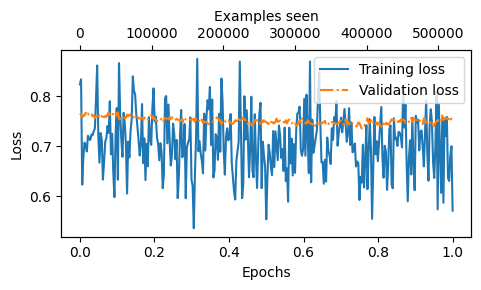

In [18]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [21]:
torch.manual_seed(42) # For reproducibility due to the shuffling in the training data loader

val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=200)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=200)

print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Validation accuracy: 67.61%
Test accuracy: 66.11%


#### inference

In [22]:
checkpoint = torch.load('models/Last_two_3.pth')
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [23]:
model.to(device)
accuracy_confusion_matrix(model, device, test_loader)

Accuracy: 0.66
Confusion Matrix:
[[7855 1893  150   31   71]
 [1967 6289 1540  145   59]
 [ 257 1998 5703 1788  254]
 [  52  159 1557 5583 2649]
 [  69   48  189 1923 7771]]


array([[7855, 1893,  150,   31,   71],
       [1967, 6289, 1540,  145,   59],
       [ 257, 1998, 5703, 1788,  254],
       [  52,  159, 1557, 5583, 2649],
       [  69,   48,  189, 1923, 7771]])

### Training with last three layer

In [13]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 21,268,997


In [14]:
# 1 epoch
import time
from train import *
start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 8.524, Val loss 8.710
Ep 1 (Step 000050): Train loss 1.850, Val loss 1.769
Ep 1 (Step 000100): Train loss 1.624, Val loss 1.651
Ep 1 (Step 000150): Train loss 1.702, Val loss 1.631
Ep 1 (Step 000200): Train loss 1.618, Val loss 1.634
Ep 1 (Step 000250): Train loss 1.709, Val loss 1.658
Ep 1 (Step 000300): Train loss 1.604, Val loss 1.623
Ep 1 (Step 000350): Train loss 1.603, Val loss 1.636
Ep 1 (Step 000400): Train loss 1.636, Val loss 1.617
Ep 1 (Step 000450): Train loss 1.595, Val loss 1.603
Ep 1 (Step 000500): Train loss 1.589, Val loss 1.601
Ep 1 (Step 000550): Train loss 1.566, Val loss 1.576
Ep 1 (Step 000600): Train loss 1.516, Val loss 1.512
Ep 1 (Step 000650): Train loss 1.383, Val loss 1.346
Ep 1 (Step 000700): Train loss 1.147, Val loss 1.160
Ep 1 (Step 000750): Train loss 1.100, Val loss 1.043
Ep 1 (Step 000800): Train loss 1.041, Val loss 1.015
Ep 1 (Step 000850): Train loss 0.965, Val loss 0.976
Ep 1 (Step 000900): Train loss 0.950, Val loss

In [15]:
# 2 epoch
import time
from train import *
start_time = time.time()

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.864, Val loss 0.778
Ep 1 (Step 000050): Train loss 0.894, Val loss 0.781
Ep 1 (Step 000100): Train loss 0.678, Val loss 0.765
Ep 1 (Step 000150): Train loss 0.697, Val loss 0.760
Ep 1 (Step 000200): Train loss 0.739, Val loss 0.776
Ep 1 (Step 000250): Train loss 0.703, Val loss 0.774
Ep 1 (Step 000300): Train loss 0.697, Val loss 0.778
Ep 1 (Step 000350): Train loss 0.730, Val loss 0.793
Ep 1 (Step 000400): Train loss 0.735, Val loss 0.769
Ep 1 (Step 000450): Train loss 0.708, Val loss 0.785
Ep 1 (Step 000500): Train loss 0.723, Val loss 0.773
Ep 1 (Step 000550): Train loss 0.720, Val loss 0.764
Ep 1 (Step 000600): Train loss 0.745, Val loss 0.771
Ep 1 (Step 000650): Train loss 0.732, Val loss 0.769
Ep 1 (Step 000700): Train loss 0.808, Val loss 0.775
Ep 1 (Step 000750): Train loss 0.886, Val loss 0.775
Ep 1 (Step 000800): Train loss 0.739, Val loss 0.794
Ep 1 (Step 000850): Train loss 0.688, Val loss 0.772
Ep 1 (Step 000900): Train loss 0.740, Val loss

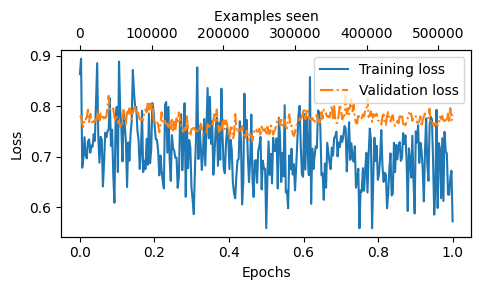

In [18]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Ep 1 (Step 000000): Train loss 0.672, Val loss 0.754
Ep 1 (Step 000050): Train loss 0.622, Val loss 0.785
Ep 1 (Step 000100): Train loss 0.791, Val loss 0.773
Ep 1 (Step 000150): Train loss 0.803, Val loss 0.798
Ep 1 (Step 000200): Train loss 0.639, Val loss 0.784
Ep 1 (Step 000250): Train loss 0.654, Val loss 0.788
Ep 1 (Step 000300): Train loss 0.708, Val loss 0.775
Ep 1 (Step 000350): Train loss 0.744, Val loss 0.804
Ep 1 (Step 000400): Train loss 0.631, Val loss 0.797
Ep 1 (Step 000450): Train loss 0.594, Val loss 0.800
Ep 1 (Step 000500): Train loss 0.704, Val loss 0.777
Ep 1 (Step 000550): Train loss 0.778, Val loss 0.792
Ep 1 (Step 000600): Train loss 0.611, Val loss 0.785
Ep 1 (Step 000650): Train loss 0.784, Val loss 0.786
Ep 1 (Step 000700): Train loss 0.689, Val loss 0.777
Ep 1 (Step 000750): Train loss 0.610, Val loss 0.782
Ep 1 (Step 000800): Train loss 0.681, Val loss 0.785
Ep 1 (Step 000850): Train loss 0.609, Val loss 0.772
Ep 1 (Step 000900): Train loss 0.600, Val loss

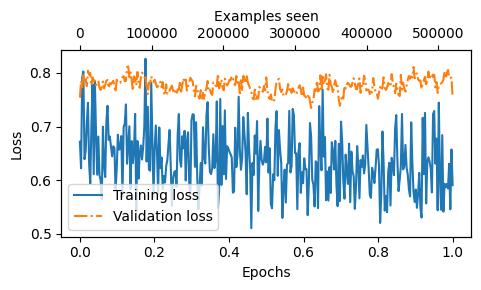

In [20]:
# 3 epoch
import time
from train import *
start_time = time.time()


num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")
# plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Ep 1 (Step 000000): Train loss 0.576, Val loss 0.838
Ep 1 (Step 000050): Train loss 0.563, Val loss 0.837
Ep 1 (Step 000100): Train loss 0.617, Val loss 0.832
Ep 1 (Step 000150): Train loss 0.638, Val loss 0.839
Ep 1 (Step 000200): Train loss 0.659, Val loss 0.831
Ep 1 (Step 000250): Train loss 0.647, Val loss 0.832
Ep 1 (Step 000300): Train loss 0.517, Val loss 0.832
Ep 1 (Step 000350): Train loss 0.526, Val loss 0.838
Ep 1 (Step 000400): Train loss 0.581, Val loss 0.831
Ep 1 (Step 000450): Train loss 0.559, Val loss 0.836
Ep 1 (Step 000500): Train loss 0.593, Val loss 0.841
Ep 1 (Step 000550): Train loss 0.544, Val loss 0.836
Ep 1 (Step 000600): Train loss 0.523, Val loss 0.839
Ep 1 (Step 000650): Train loss 0.565, Val loss 0.835
Ep 1 (Step 000700): Train loss 0.561, Val loss 0.843
Ep 1 (Step 000750): Train loss 0.606, Val loss 0.847
Ep 1 (Step 000800): Train loss 0.665, Val loss 0.844
Ep 1 (Step 000850): Train loss 0.686, Val loss 0.842
Ep 1 (Step 000900): Train loss 0.625, Val loss

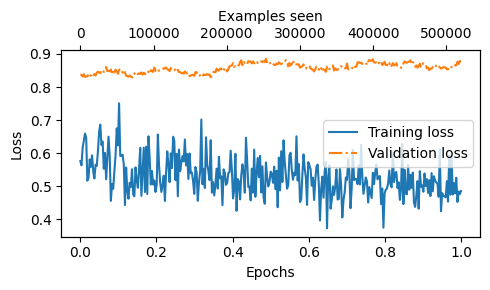

In [22]:
# 4 epoch
start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")
# plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

As we can see here, on the forth epoch, we start to experience over-fitting. So we decide to stop training.

In [23]:
torch.manual_seed(42) # For reproducibility due to the shuffling in the training data loader

val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=200)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=200)

print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Validation accuracy: 67.00%
Test accuracy: 66.09%


#### inference

In [28]:
checkpoint = torch.load('models/Last_three_4.pth')
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [29]:
model.to(device)
accuracy_confusion_matrix(model, device, test_loader)

Accuracy: 0.66
Confusion Matrix:
[[7728 1930  225   54   63]
 [1900 6047 1839  162   52]
 [ 228 1812 5744 1992  224]
 [  52  129 1433 5929 2457]
 [  65   43  181 2200 7511]]


array([[7728, 1930,  225,   54,   63],
       [1900, 6047, 1839,  162,   52],
       [ 228, 1812, 5744, 1992,  224],
       [  52,  129, 1433, 5929, 2457],
       [  65,   43,  181, 2200, 7511]])

## Conclusion

After finetuning 4 different transformer model based on a pretrained GPT2 architecture. We observed that the LoRA model and all layers model performed best even trained with less epochs. However it may take about 27% longer to train. The reason might be it is more flexible and therefore more capable of handling complex context. We also observed that training only with last several layers is more prone to over-fitting. As we can see for the last epoch, the training loss is much lower than the validation loss. But we do not see that when we train all layers together. The reason for that might be by reducing the number of trainable parameters, we also reduced the capability of the model to generalize to more complex context. So the model would simply try to memorize instead of learning the pattern. Which ultimately caused the over-fitting. Based on those factors we would like to train more on all layer model to see if we can achive a better benchmark